In [1]:
import os 
os.chdir('/home/xinglong/git_local/ssm-jax')
import jax
jax.config.update('jax_platform_name', 'cpu')

# Causal Impact Jax

The causal impact R package: <a href="https://google.github.io/CausalImpact/CausalImpact.html"> CausalImpact</a> is built upon the R package <a href="https://cran.r-project.org/web/packages/bsts/bsts.pdf"> bsts </a> for Bayesian structural time series models.

There are some python packages that implement the causal impact algorithm with python:
* The package <a href="https://github.com/WillianFuks/tfcausalimpact"> tfcausalimpact </a> is built upon the 
<a href="https://www.tensorflow.org/probability/api_docs/python/tfp/sts"> tfp.sts module </a>.
* The package <a href="https://pypi.org/project/pycausalimpact/"> pycausalimpact </a> is built upon the package
 <a href="https://github.com/statsmodels/statsmodels"> statsmodels </a>.
* The package <a href="https://github.com/jamalsenouci/causalimpact"> causalimpact </a> is also built upon the package ‘statsmodel’.

The R package ‘bsts’, python packages ‘tfp.sts’, and ‘statsmodels’ all contain functions that build the structural time series model and perform posterior inference and forecast predictions.

## Causal impact

## Example 

Use the same example as in the R package <a href="http://google.github.io/CausalImpact/CausalImpact.html"> CausalImpact</a>.

In [2]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

from causal_impact import causal_impact

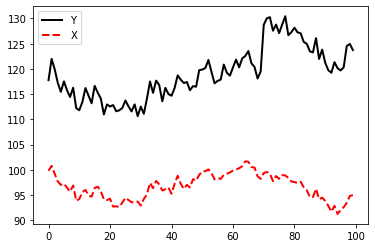

In [3]:
num_timesteps = 100

def auto_regress(x, key):
    x_new = 0.99 * x + jr.normal(key)
    return x_new, x

key = jr.PRNGKey(0)
x0 = jr.normal(key)
keys = jr.split(key, num_timesteps)
_, x =  lax.scan(auto_regress, x0, keys)
x = x + 100

y = 1.2*x + jr.normal(key, shape=(num_timesteps,))
y = y.at[70:].set(y[70:]+10)

plt.plot(y, label='Y', color='black', lw=2)
plt.plot(x, linestyle='dashed', color='red', lw=2, label='X')
plt.legend()

In [4]:
# Run an anlysis
observed_timeseries = jnp.expand_dims(y, 1)
inputs = jnp.concatenate((jnp.ones((num_timesteps, 1)), jnp.expand_dims(x, 1)), axis=1)
intervention_time = 70


In [5]:
import ssm_jax.structural_time_series.models.structural_time_series as sts

sts_model=None
confidence_level=0.95
key=jr.PRNGKey(0)
sample_size=200

key1, key2, key3 = jr.split(key, 3)
num_timesteps, dim_obs = observed_timeseries.shape

# Split the data into pre-intervention period and post-intervention period
timeseries_pre = observed_timeseries[:intervention_time]
timeseries_pos = observed_timeseries[intervention_time:]

if inputs is not None:
    dim_inputs = inputs.shape[-1]
    # The number of time steps of input must equal to that of observed time_series.
    inputs_pre = inputs[:intervention_time]
    inputs_pos = inputs[intervention_time:]

# Construct a STS model with only local linear trend by default
if sts_model is None:
    local_linear_trend = sts.LocalLinearTrend(observed_timeseries=observed_timeseries)
    if inputs is None:
        sts_model = sts.StructuralTimeSeries(components=[local_linear_trend],
                                             observed_timeseries=observed_timeseries)
    else:
        linear_regression = sts.LinearRegression(weights_shape=(dim_obs, dim_inputs))
        sts_model = sts.StructuralTimeSeries(components=[local_linear_trend, linear_regression],
                                             observed_timeseries=observed_timeseries)


In [6]:
sts_ssm = sts_model.as_ssm()
batch_observed_time_series = jnp.array([timeseries_pre]) 
batch_inputs = jnp.array([inputs_pre])
warmup_steps=500
num_integration_steps=30
self = sts_ssm


In [7]:
from ssm_jax.structural_time_series.new_parameters import (
    to_unconstrained, from_unconstrained, log_det_jac_constrain, ParameterProperties)
from jax import jit, vmap
import blackjax
from jax.tree_util import tree_map
from tqdm.auto import trange
batch_emissions = batch_observed_time_series

def logprob(trainable_unc_params):
    params = from_unconstrained(trainable_unc_params, fixed_params, self.param_props)
    log_det_jac = log_det_jac_constrain(trainable_unc_params, fixed_params, self.param_props)
    log_pri = self.log_prior(params) + log_det_jac
    batch_lls = vmap(self.marginal_log_prob)(batch_emissions, batch_inputs, params)
    lp = log_pri + batch_lls.sum()
    return lp


In [8]:
# Initialize the HMC sampler using window_adaptations
hmc_initial_position, fixed_params = to_unconstrained(self.params, self.param_props)

In [10]:
warmup = blackjax.window_adaptation(blackjax.hmc,
                                    logprob,
                                    num_steps=warmup_steps,
                                    num_integration_steps=num_integration_steps)
hmc_initial_state, hmc_kernel, _ = warmup.run(key, hmc_initial_position)


TypeError: dot_general requires contracting dimensions to have the same shape, got (0,) and (2,).

In [ ]:

@jit
def _step(current_state, rng_key):
    next_state, _ = hmc_kernel(rng_key, current_state)
    unc_sample = next_state.position
    return next_state, unc_sample

keys = iter(jr.split(key, sample_size))
param_samples = []
current_state = hmc_initial_state
for _ in trange(sample_size):
    current_state, unc_sample = _step(current_state, next(keys))
    sample = from_unconstrained(unc_sample, fixed_params, self.param_props)
    param_samples.append(sample)

param_samples = tree_map(lambda x, *y: jnp.array([x] + [i for i in y]),
                         param_samples[0], *param_samples[1:])

In [ ]:
param_samps = sts_ssm.fit_hmc(key, sample_size, batch_observed_time_series, batch_inputs)

In [ ]:
params_posterior_samples = sts_model.fit_hmc(
    key1, sample_size, jnp.array([timeseries_pre]), jnp.array([inputs_pre]))

In [ ]:

# Fit the STS model, sample from the past and forecast.
if inputs is not None:
    # Model fitting
    print('Fit the model using HMC...')
    params_posterior_samples = sts_model.fit_hmc(
        key1, sample_size, jnp.array([timeseries_pre]), jnp.array([inputs_pre]))
    print("Model fitting completed.")
    # Sample from the past and forecast
    samples_pre = sts_model.posterior_sample(
        key2, timeseries_pre, params_posterior_samples, inputs_pre)
    samples_pos = sts_model.forecast(
        key3, timeseries_pre, params_posterior_samples, timeseries_pos.shape[0],
        inputs_pre, inputs_pos)
else:
    # Model fitting
    print('Fit the model using HMC...')
    params_posterior_samples = sts_model.fit_hmc(key1, sample_size, jnp.array([timeseries_pre]))
    print("Model fitting completed.")
    # Sample from the past and forecast
    samples_pre = sts_model.posterior_sample(key2, timeseries_pre, params_posterior_samples)
    samples_pos = sts_model.forecast(
        key3, timeseries_pre, params_posterior_samples, timeseries_pos.shape[0])

In [ ]:

impact = causal_impact(observed_timeseries, intervention_time, inputs)

In [ ]:
# Print the summaries of the inferred causal impact
impact.summary()

In [ ]:
# Plot the inferred causal impact
impact.plot()